#DATA 620 Project 2
**Team 2:** Christophe Hunt, Joel Park, Ilya Kats, Pavan Akula, Nathan (Seoungyoon) Lim

###Project Description

The goal of the project is to create and analyze a two-node social network for sponsorship of bill and interests group affiliation within the U.S. Senate. Any mention of *bills* below implies *bills and resolutions*. Bills can be introduced by several senators, but only one, whose name appears first on the bill, is considered its sponsor. Senator may sponsor a bill for various reasons - because they support it, because they want to have a record of supporting it, because their constituents request it, and even to show support for bill's sponsor. Sometimes Senator may sponsor a bill to get campaign contributions to get elected to public office. Companies, labor unions, and other organizations spend billions of dollars each year on lobbying Congress and federal agencies. Before a bill is drafted Senator's staff, lobbyists and special interests groups work together tirelessly. Each bill is classified into a *subject* based on its *legislative* purpose. We will be analyzing the relationship between *Senators* and *Subjects* they are interested in. This type of social network is known as *affiliation* or *bipartite* networks.

###Specific project requirements:

- Identify a large two-node network dataset. Data should meet the criteria that it consists of ties between and not within two (or more) distinct groups.
- Reduce the size of the network using a method such as the island method described in chapter 4 of social network analysis.
- What can you infer about each of the distinct groups?

###We will be extracting following information from the data

- Senators presenting most bills
- Subjects on which most bills are presented.

###Data Source

For the project, we are analyzing affiliation between sponsors and subjects of bills within the U.S. Senate of the 114th Congress that met from January 3, 2015, to January 3, 2017. The official repository of the U.S. legislative data is Congress.gov. The bills data is also maintained by the U.S. Government Publishing Office. The data for the 114th Congress is available at https://www.gpo.gov/fdsys/bulkdata/BILLSTATUS/114/. The data is stored in XML format and contains a significant amount of metadata to describe a bill and its activity in Congress.

The public @unitedstates project maintains data and tools to access and analyze the governmental data including congressional data. Our primary data source is archived bills data from the 114th Congress prepared by the Sunlight Foundation. The data is saved in JSON format. Data access and format description is available at https://github.com/unitedstates/congress/wiki.

###Data Import

After downloading bills information from https://www.gpo.gov/fdsys/bulkdata/BILLSTATUS/114/, we have extracted required data and saved it to MySQL relational database on Google Cloud.

In [1]:
#Libraries used
import numpy as np
import pymysql
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms import bipartite

In [2]:
#Retrieve data from cloud database
sql_con = pymysql.connect(host='104.196.212.179', port=3306, user='root', passwd='data620pw', db='billsdata')

query = ("SELECT senator, `subject`, COUNT(1) AS weight FROM "
        "(SELECT DISTINCT b.billId, b.title, s.`name` AS senator, ss.mainSubject as `subject` "
        "FROM sponsors s "
        "JOIN subjects ss ON s.billid = ss.billid "
        "JOIN bills b ON s.billid = b.billid ) a "
        "GROUP BY senator, `subject`;")

subjectInfo = pd.read_sql(query, con=sql_con)

#Small subset of data
query = ("SELECT senator, `subject`, COUNT(1) AS weight FROM "
        "(SELECT DISTINCT b.billId, b.title, s.`name` AS senator, ss.mainSubject AS `subject` "
        "FROM sponsors s "
        "JOIN subjects ss ON s.billid = ss.billid "
        "JOIN bills b ON s.billid = b.billid "
        "WHERE s.`name` IN ('Harry Reid','Elizabeth Warren', 'Mitch McConnell','Jeff Sessions','Bernard Sanders') ) a "
        "GROUP BY senator, `subject`")

smallSubset = pd.read_sql(query, con=sql_con)

sql_con.close()

#Seperate data into senators and billsubject
senatorsList = subjectInfo.senator.unique()
subjectList = subjectInfo.subject.unique()

senatorsList = senatorsList.tolist()
subjectList = subjectList.tolist()

#Small subset
subSetsenatorsList = smallSubset.senator.unique()
subSetsubjectList = smallSubset.subject.unique()

subSetsenatorsList = subSetsenatorsList.tolist()
subSetsubjectList = subSetsubjectList.tolist()

###Classification of bills sponsored by Senator based on subject.

In [3]:
#Weight shows number of bills presented on a subject by Senator
subjectInfo.sort_values(['weight'], ascending = False, inplace=True)
subjectInfo

senator                              subject  weight
710        Lisa Murkowski                               Energy      30
887        Orrin G. Hatch                             Taxation      23
204        Chuck Grassley                               Health      21
716        Lisa Murkowski   Public lands and natural resources      17
290          David Vitter                               Health      17
638            Jon Tester   Armed forces and national security      15
107          Bill Cassidy                               Health      15
645            Jon Tester                     Native Americans      14
280          David Vitter                             Commerce      13
1135        Sherrod Brown                               Health      13
859           Mike Rounds   Armed forces and national security      13
1090            Ron Wyden   Public lands and natural resources      13
199        Chuck Grassley            Crime and law enforcement      13
359      Edward J. Markey                               Energy      13
1093            Ron Wyden                             Taxation      12
761      Mark Steven Kirk   Armed forces and national security      12
465        Jeanne Shaheen   Armed forces and national security      12
626            John Thune                             Taxation      12
523           Jerry Moran   Armed forces and national security      11
769      Mark Steven Kirk                               Health      11
562         John Barrasso                     Native Americans      11
151    Charles E. Schumer            Crime and law enforcement      11
1050  Robert P. Jr. Casey                               Health      11
301           Dean Heller   Armed forces and national security      11
83     Benjamin L. Cardin                International affairs      11
1073          Ron Johnson   Government operations and politics      11
5              Al Franken                               Health      11
957    Richard Blumenthal   Armed forces and national security      10
872        Orrin G. Hatch            Crime and law enforcement      10
728           Marco Rubio                International affairs      10
...                   ...                                  ...     ...
623            John Thune                     Native Americans       1
629        Johnny Isakson         Economics and public finance       1
630        Johnny Isakson   Government operations and politics       1
572          John Boozman                               Energy       1
570          John Boozman              Arts, culture, religion       1
568          John Boozman                 Agriculture and food       1
546          Joe Donnelly                 Labor and employment       1
531           Jerry Moran                                  Law       1
533           Jerry Moran   Public lands and natural resources       1
534           Jerry Moran  Science, technology, communications       1
537           Jerry Moran          Water resources development       1
539          Joe Donnelly            Crime and law enforcement       1
540          Joe Donnelly                            Education       1
541          Joe Donnelly             Environmental protection       1
543          Joe Donnelly   Government operations and politics       1
544          Joe Donnelly                               Health       1
545          Joe Donnelly    Housing and community development       1
547          Joe Donnelly      Transportation and public works       1
566         John Barrasso      Transportation and public works       1
548       Joe Manchin III   Armed forces and national security       1
549       Joe Manchin III         Economics and public finance       1
551       Joe Manchin III         Finance and financial sector       1
552       Joe Manchin III   Government operations and politics       1
554       Joe Manchin III                 Labor and employment       1
555       Joe Manchin III   Public lands a

Lisa Murkowski is the Chairman of Committee on Energy and Natural Resources. Orrin G. Hatch is the Chairman of Committee on Finance.

###Two-mode Network Graph

Following graph shows two sets of nodes and relationships between sets. The first set of nodes are Senators and second set is a bill subject. Sets of nodes are related, but there is no relation between each set of nodes. This shows there is no connection between Senators. We can also notice there is no link between bill subjects.

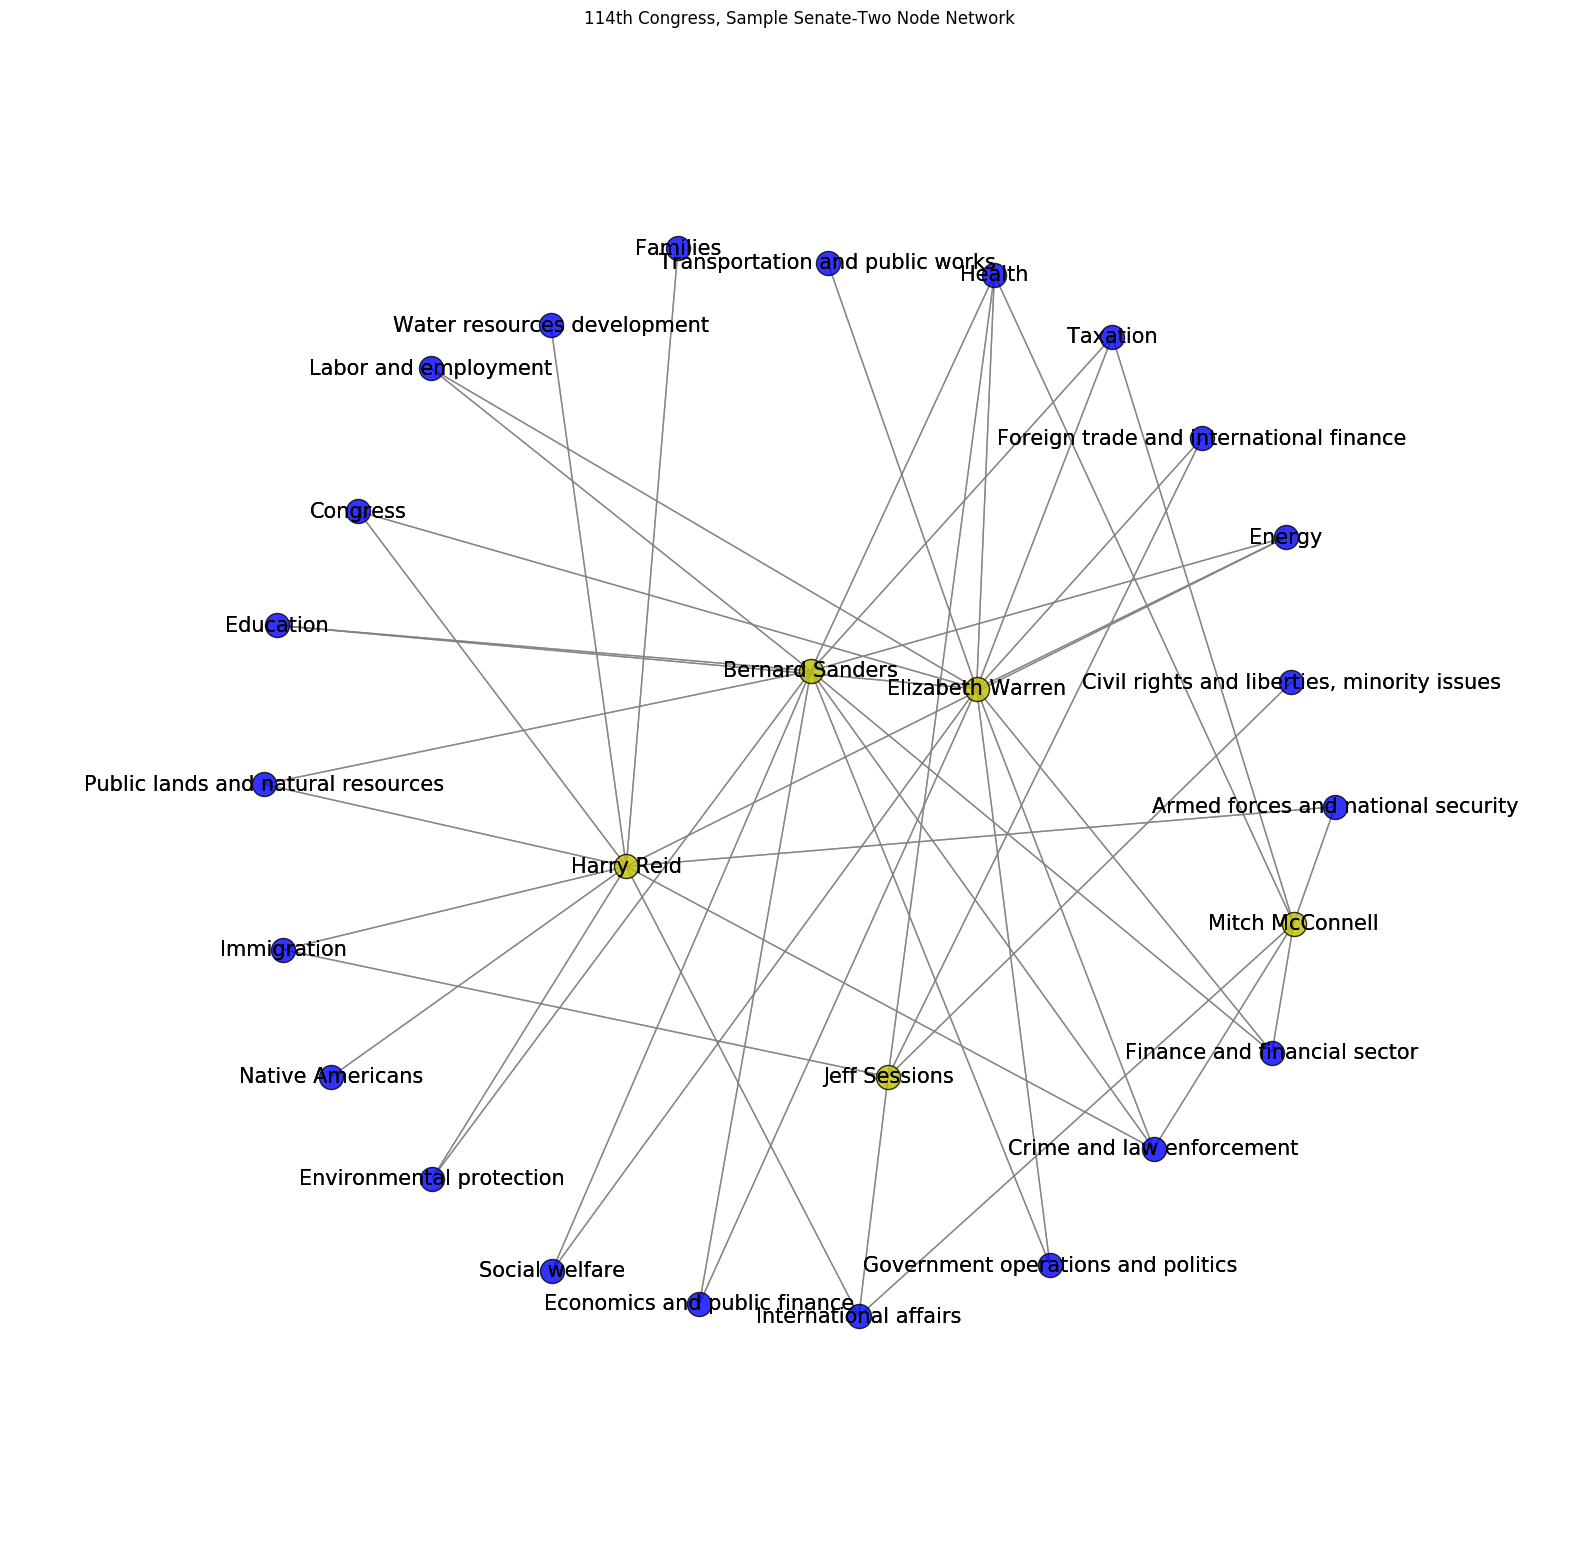

In [4]:
#Small subset data to show two-mode graph
%matplotlib inline

fig = plt.figure(figsize=(15, 15))
B = nx.Graph()
B.add_nodes_from(subSetsenatorsList, bipartite=0) # Add the node attribute "bipartite"
B.add_nodes_from(subSetsubjectList, bipartite=1)

for index, row in smallSubset.iterrows():
    B.add_edge(row['senator'], row['subject'], weight=row['weight'])

#pos = nx.spring_layout(B, k=0.5, iterations=2)
pos = nx.spring_layout(B, k=0.5, iterations=25)
nx.draw(B, nodelist = subSetsenatorsList, with_labels=True, pos=pos, font_size=15, alpha=.8, edge_color = 'grey', node_color = 'y', arrows=True)
nx.draw(B, nodelist = subSetsubjectList, with_labels=True, pos=pos, font_size=15, alpha=.8, edge_color = 'grey', node_color = 'b', arrows=True)

plt.title('114th Congress, Sample Senate-Two Node Network')
plt.show()

Following is an entire two-mode graph showing a relationship between Senators and bill subjects. We will be working with the whole dataset for the rest of the project.

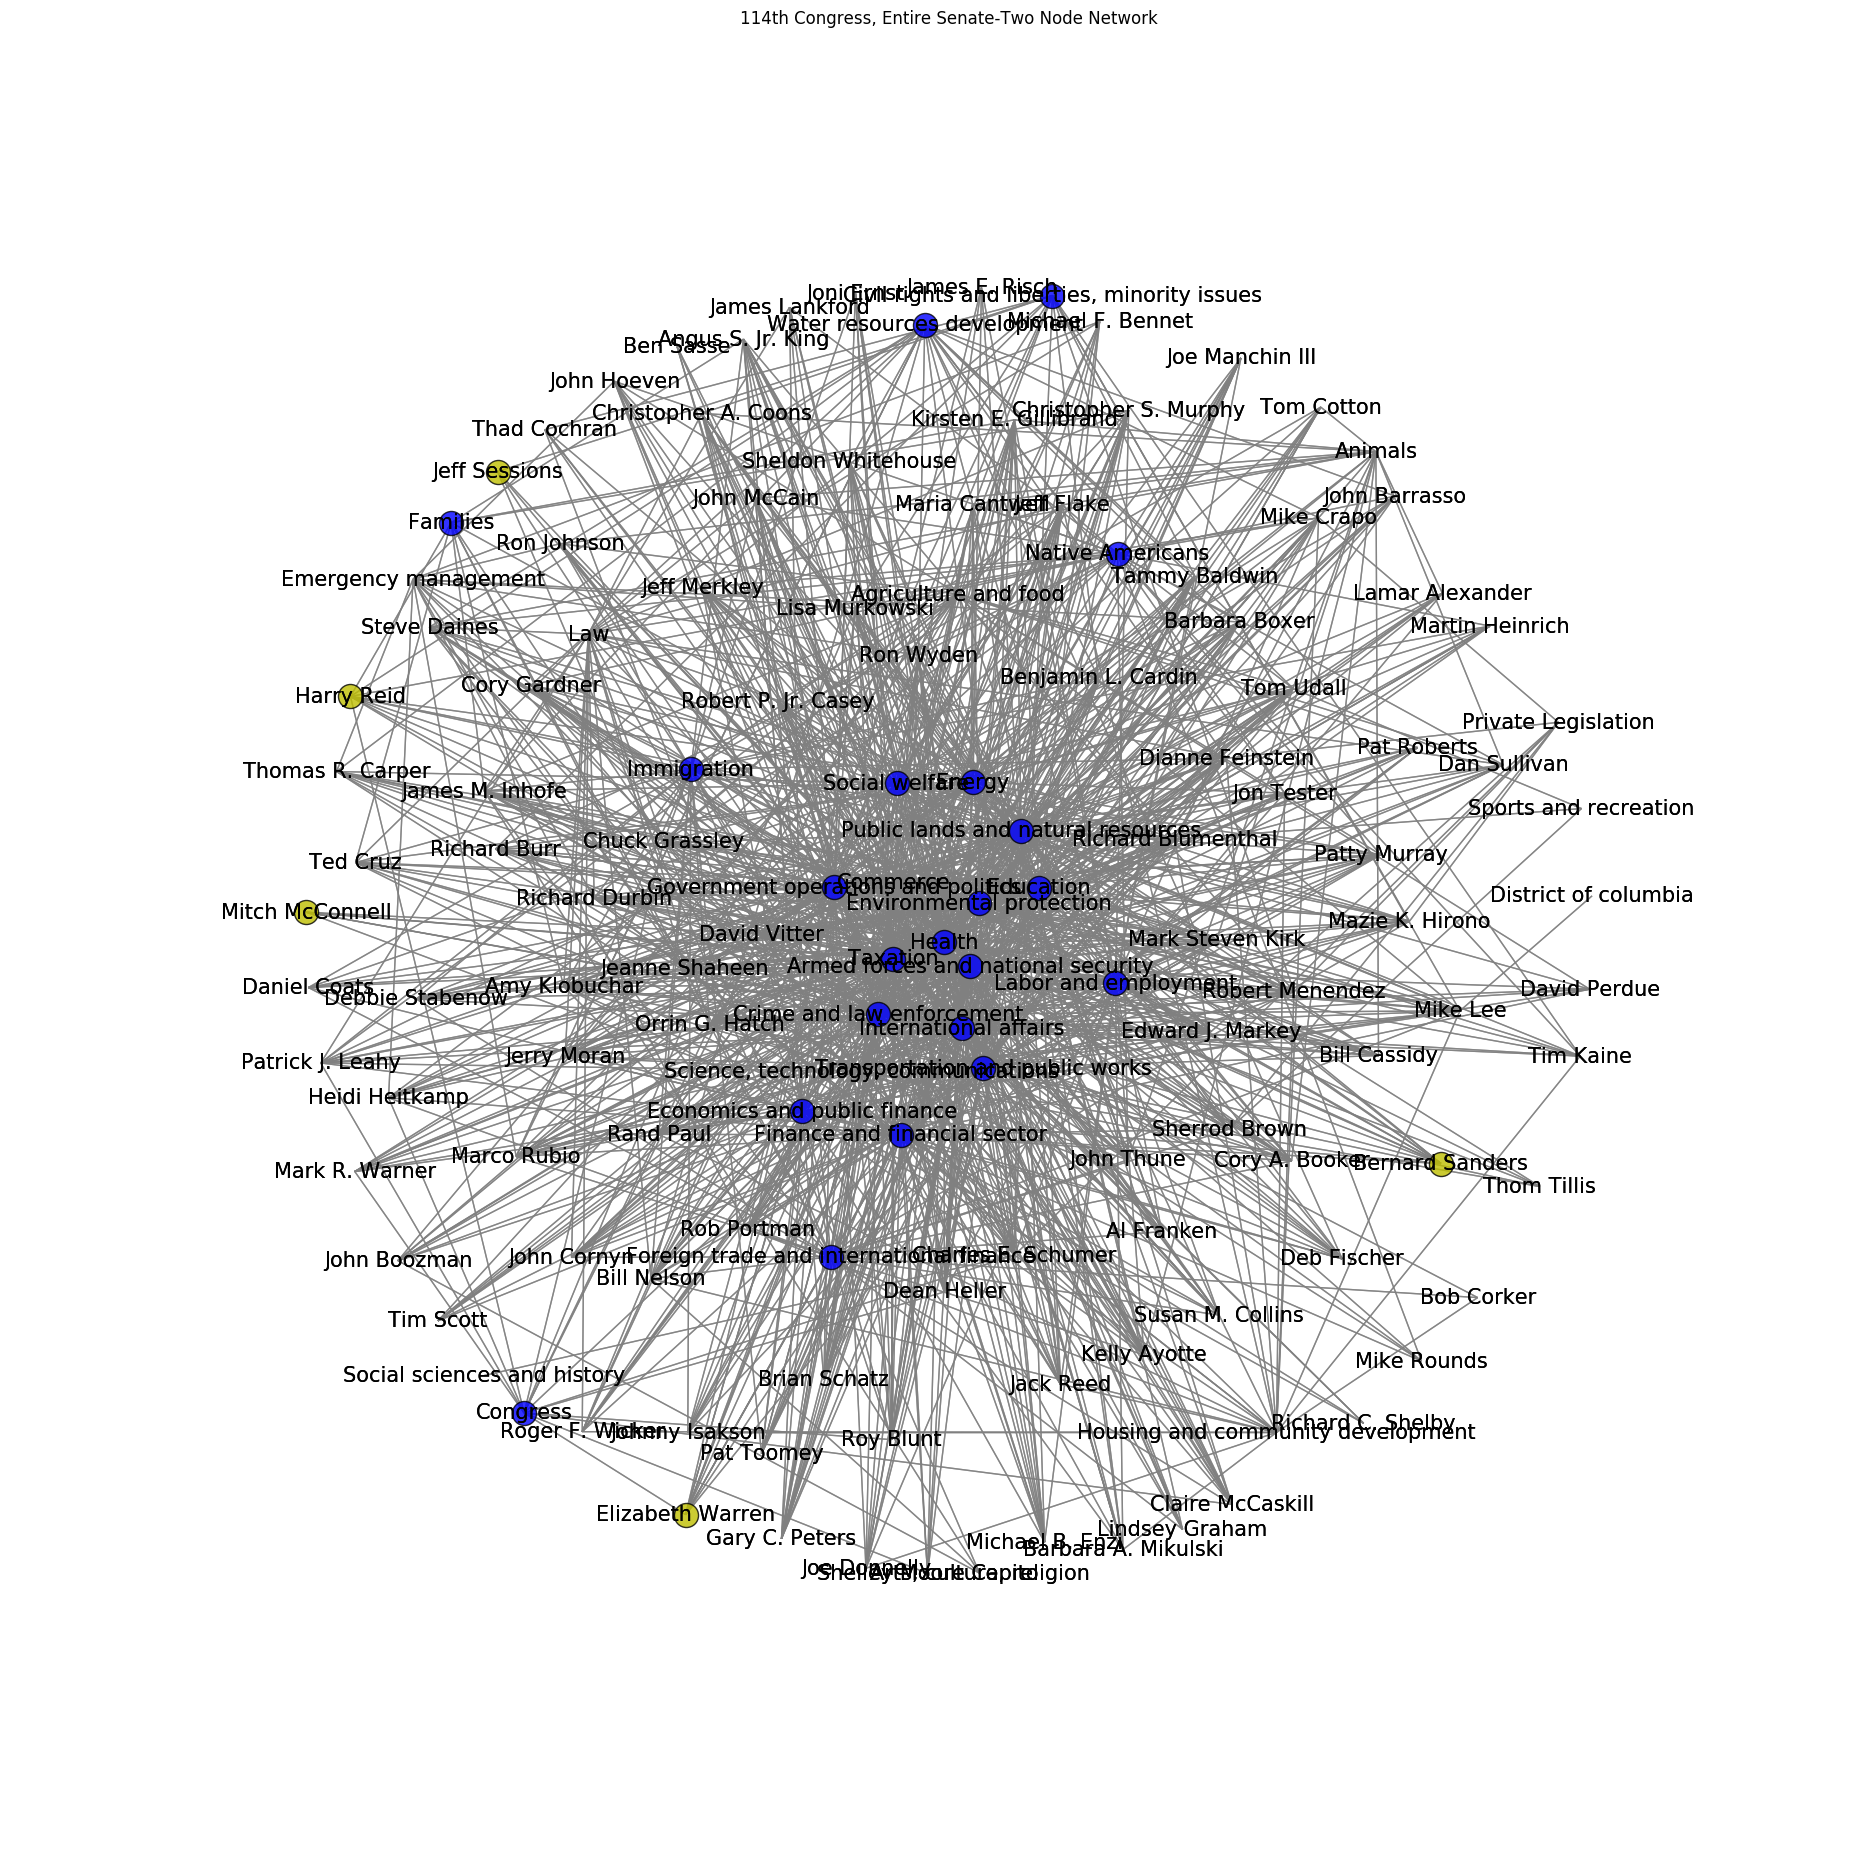

In [5]:
%matplotlib inline
fig = plt.figure(figsize=(18, 18))
B = nx.Graph()
B.add_nodes_from(senatorsList, bipartite=0) # Add the node attribute "bipartite"
B.add_nodes_from(subjectList, bipartite=1)

for index, row in subjectInfo.iterrows():
    B.add_edge(row['senator'], row['subject'], weight=row['weight'])

#pos = nx.spring_layout(B, k=0.5, iterations=2)
pos = nx.spring_layout(B, k=0.3, iterations=75)
nx.draw(B, nodelist = subSetsenatorsList, with_labels=True, pos=pos, font_size=15, alpha=.8, edge_color = 'grey', node_color = 'y', arrows=True)
nx.draw(B, nodelist = subSetsubjectList, with_labels=True, pos=pos, font_size=15, alpha=.8, edge_color = 'grey', node_color = 'b', arrows=True)

plt.title('114th Congress, Entire Senate-Two Node Network')
plt.show()

Get information about node sets. There are 100 Senators and 34 bill subjects.

In [6]:
#Graph can be queried to get information about node sets
top_nodes, bottom_nodes = bipartite.sets(B)

#Total of 100 Senators
print (len(top_nodes))

#Senators
df = pd.DataFrame(list(top_nodes), columns=['Senators'])
df

100


Senators
0             Rob Portman
1          Johnny Isakson
2            David Perdue
3          Gary C. Peters
4              John Thune
5        Claire McCaskill
6         Bernard Sanders
7         Lamar Alexander
8               Roy Blunt
9           Jeff Sessions
10           Brian Schatz
11          John Barrasso
12        James M. Inhofe
13         Lisa Murkowski
14         Cory A. Booker
15              Tim Scott
16     Sheldon Whitehouse
17         Richard Durbin
18     Benjamin L. Cardin
19               Mike Lee
20             Jeff Flake
21        Mitch McConnell
22        Mazie K. Hirono
23         Jeanne Shaheen
24           Patty Murray
25     Richard Blumenthal
26           Cory Gardner
27           Steve Daines
28             Harry Reid
29       Susan M. Collins
..                    ...
70           Jeff Merkley
71            Dean Heller
72       Thomas R. Carper
73         Mark R. Warner
74            Bill Nelson
75           Kelly Ayotte
76            Pat Roberts
77        Michael B. Enzi
78         Lindsey Graham
79            Deb Fischer
80          Sherrod Brown
81               Ted Cruz
82         James E. Risch
83  Kirsten E. Gillibrand
84  Christopher S. Murphy
85        Joe Manchin III
86       Elizabeth Warren
87   Christopher A. Coons
88            Jerry Moran
89           Daniel Coats
90           Joe Donnelly
91        Robert Menendez
92           Dan Sullivan
93             Joni Ernst
94   Shelley Moore Capito
95       Dianne Feinstein
96         James Lankford
97              Ben Sasse
98              Ron Wyden
99          Tammy Baldwin

[100 rows x 1 columns]

In [7]:
#Total of 34 Bill Subjects
print (len(bottom_nodes))

#Bill Subjects
df = pd.DataFrame(list(bottom_nodes), columns=['Subjects'])
df

34


Subjects
0                                      Commerce
1                     Crime and law enforcement
2                  Finance and financial sector
3            Government operations and politics
4                              Native Americans
5                                           Law
6                                      Families
7                           Private Legislation
8                   Social sciences and history
9                          Labor and employment
10                         Emergency management
11                                  Immigration
12                                       Health
13                        Sports and recreation
14           Public lands and natural resources
15                                     Taxation
16                     Environmental protection
17  Civil rights and liberties, minority issues
18                        International affairs
19                      Arts, culture, religion
20                                       Energy
21                  Water resources development
22           Armed forces and national security
23                 Economics and public finance
24          Science, technology, communications
25      Foreign trade and international finance
26                               Social welfare
27                                      Animals
28                         Agriculture and food
29                                     Congress
30            Housing and community development
31                         District of columbia
32                                    Education
33              Transportation and public works

In [8]:
#Get total number of nodes in the graph (Senators + Bill Subjects)
bipartite.sets(B)
nx.number_of_nodes(B)

134

In [9]:
#Diameter of the graph. Total number of bill presented by Senators during 114th congress.
print(B.size())

1265


In [10]:
#Displays information how nodes are grouped inside the graph
#Senators bipartite value is 1 and bill subject bipartite value is 0
df = pd.DataFrame(list(bipartite.color(B).items()), columns=['Node', 'bipartite'])
df.sort_values(['bipartite', 'Node'], ascending = True, inplace=True)
df

Node  bipartite
120                         Agriculture and food          0
31                                       Animals          0
49            Armed forces and national security          0
96                       Arts, culture, religion          0
105  Civil rights and liberties, minority issues          0
57                                      Commerce          0
124                                     Congress          0
3                      Crime and law enforcement          0
18                          District of columbia          0
56                  Economics and public finance          0
128                                    Education          0
16                          Emergency management          0
44                                        Energy          0
37                      Environmental protection          0
39                                      Families          0
80                  Finance and financial sector          0
14       Foreign trade and international finance          0
7             Government operations and politics          0
91                                        Health          0
66             Housing and community development          0
23                                   Immigration          0
40                         International affairs          0
87                          Labor and employment          0
11                                           Law          0
81                              Native Americans          0
84                           Private Legislation          0
99            Public lands and natural resources          0
117          Science, technology, communications          0
86                   Social sciences and history          0
122                               Social welfare          0
..                                           ...        ...
62                                   Pat Roberts          1
43                                    Pat Toomey          1
130                             Patrick J. Leahy          1
67                                  Patty Murray          1
111                                    Rand Paul          1
69                            Richard Blumenthal          1
42                                  Richard Burr          1
1                              Richard C. Shelby          1
8                                 Richard Durbin          1
19                                   Rob Portman          1
104                              Robert Menendez          1
79                           Robert P. Jr. Casey          1
106                              Roger F. Wicker          1
116                                  Ron Johnson          1
132                                    Ron Wyden          1
20                                     Roy Blunt          1
46                            Sheldon Whitehouse          1
113                         Shelley Moore Capito          1
71                                 Sherrod Brown          1
75                                  Steve Daines          1
123                             Susan M. Collins          1
133                                Tammy Baldwin          1
127                                     Ted Cruz          1
10                                  Thad Cochran          1
88                                   Thom Tillis          1
53                              Thomas R. Carper          1
13                                     Tim Kaine          1
64                                     Tim Scott          1
93                                    Tom Cotton          1
109                                    Tom Udall          1

[134 rows x 2 columns]

#Metrics and Inference

###Shortest Path

Function *shortest_path_length* of *NetworkX* library allows us to find the *Shortest Path* from a specific origin to a specified destination in a given network while minimizing the total cost associated with the path. 

In our case, *shortest path* metric shows, bills sponsored by Senator Amy Klobuchar on subjects *Health* and *Science, technology, communications* make it to the floor faster compared to Senator Tom Cotton and Senator Tom Udall.

Example:
Minnesota Democratic Senator Amy Klobuchar has sponsored bills on subjects *Health* and *Science, technology, communications*. She and her staff have more experience than Arkansas Republican Senator Tom Cotton in getting these bills through committees and onto the Senate floor. If people of Arkansas want any legislation introduced related to *Health* and *Science, technology, communications* their chances of getting the bill onto the floor through Senator Amy Klobuchar are very high compared to   Senator Tom Cotton.

In [11]:
#Gives information about average shortest path between Senators and Subjects. 
#Every Senator has atleast two subjects common with other Senators.
nx.average_shortest_path_length(B)

2.116934126360678

In [12]:
#Shortest path between Senators and bill subjects
#Value is close to average shortest path.
df = pd.DataFrame(list(bipartite.color(B).items()), columns=['Node', 'bipartite'])
df1 = df[(df.bipartite == 1)]
df2 = df[(df.bipartite == 0)]

cols = ['Senator', 'Subject', 'ShortestPath']
lst = []
for i1, m1 in df1.iterrows():
    for i2, m2 in df2.iterrows():
        s1 = m1[0]
        s2 = m2[0]
        e = False
        if [s1, s2, nx.shortest_path_length(B, s1, s2)] in lst:
            e = True
        if [s2, s1, nx.shortest_path_length(B, s1, s2)] in lst:
            e = True
        if not e:
            lst.append([s1, s2, nx.shortest_path_length(B, s1, s2)])

ShortPath = pd.DataFrame(lst, columns=cols)
ShortPath.sort_values(['ShortestPath', 'Senator', 'Subject'], ascending = True, inplace=True)
ShortPath

Senator                                      Subject  ShortestPath
1137     Al Franken           Armed forces and national security             1
1122     Al Franken                    Crime and law enforcement             1
1155     Al Franken                                    Education             1
1135     Al Franken                                       Energy             1
1125     Al Franken      Foreign trade and international finance             1
1147     Al Franken                                       Health             1
1146     Al Franken                         Labor and employment             1
1124     Al Franken                                          Law             1
1149     Al Franken           Public lands and natural resources             1
1131     Al Franken                                     Taxation             1
2478  Amy Klobuchar                         Agriculture and food             1
2463  Amy Klobuchar           Armed forces and national security             1
2465  Amy Klobuchar                                     Commerce             1
2448  Amy Klobuchar                    Crime and law enforcement             1
2464  Amy Klobuchar                 Economics and public finance             1
2481  Amy Klobuchar                                    Education             1
2461  Amy Klobuchar                                       Energy             1
2458  Amy Klobuchar                     Environmental protection             1
2459  Amy Klobuchar                                     Families             1
2468  Amy Klobuchar                 Finance and financial sector             1
2451  Amy Klobuchar      Foreign trade and international finance             1
2449  Amy Klobuchar           Government operations and politics             1
2473  Amy Klobuchar                                       Health             1
2454  Amy Klobuchar                                  Immigration             1
2460  Amy Klobuchar                        International affairs             1
2472  Amy Klobuchar                         Labor and employment             1
2450  Amy Klobuchar                                          Law             1
2475  Amy Klobuchar           Public lands and natural resources             1
2477  Amy Klobuchar          Science, technology, communications             1
2457  Amy Klobuchar                                     Taxation             1
...             ...                                          ...           ...
2298     Tom Cotton                 Finance and financial sector             3
2279     Tom Cotton           Government operations and politics             3
2303     Tom Cotton                                       Health             3
2296     Tom Cotton            Housing and community development             3
2302     Tom Cotton                         Labor and employment             3
2280     Tom Cotton                                          Law             3
2299     Tom Cotton                             Native Americans             3
2300     Tom Cotton                          Private Legislation             3
2305     Tom Cotton           Public lands and natural resources             3
2307     Tom Cotton          Science, technology, communications             3
2301     Tom Cotton                  Social sciences and history             3
2285     Tom Cotton                        Sports and recreation             3
2297     Tom Cotton              Transportation and public works             3
2292     Tom Cotton                  Water resources development             3
2728      Tom Udall                                      Animals             3
2746      Tom Udall                      Arts, culture, religion             3
2748      Tom Udall  Civil rights and liberties, minority issues             3
2720      Tom Udall                    Crime and law enforcement             3
2725      Tom Udall                         District of columb

###Node centralities

We will be showing metrics

- Closeness - Closeness is the inverse sum of all shortest paths
- Betweenness - Number of shortest paths that pass through a node
- Degree - The number other nodes that a node is connected to

In our case, *Health* and *Taxation* top the list in all three metrics. In other words, both subjects unite Senators closely than any other subject. Subject *District of Columbia* least popular among Senators.

In [13]:
#Closeness centrality between Senetors and Subjects
close = nx.closeness_centrality(B)
df = pd.DataFrame(list(close.items()), columns=['Node', 'Closeness'])
df.sort_values(['Closeness', 'Node'], ascending = False, inplace=True)
df

Node  Closeness
91                                        Health   0.692708
35                                      Taxation   0.651961
99            Public lands and natural resources   0.604545
8             Government operations and politics   0.599099
72            Armed forces and national security   0.588496
131              Transportation and public works   0.545082
20                     Crime and law enforcement   0.545082
127                                    Education   0.527778
46                                  David Vitter   0.523622
41                         International affairs   0.519531
93                  Finance and financial sector   0.515504
88                      Environmental protection   0.515504
100                                Amy Klobuchar   0.515504
59                                    Jeff Flake   0.511538
121                               Orrin G. Hatch   0.507634
128                               Jeanne Shaheen   0.507634
111                                    Tom Udall   0.503788
132                                    Ron Wyden   0.503788
34                               Robert Menendez   0.503788
4                                    Rob Portman   0.503788
52                                Richard Durbin   0.503788
68                            Richard Blumenthal   0.503788
53                                      Mike Lee   0.503788
16                              Mark Steven Kirk   0.503788
19                            Charles E. Schumer   0.503788
13                                    Mike Crapo   0.500000
125                                  Marco Rubio   0.500000
28                               James M. Inhofe   0.500000
114                             Dianne Feinstein   0.500000
56                                   Bill Nelson   0.500000
..                                           ...        ...
49                                  Thad Cochran   0.458621
113                         Shelley Moore Capito   0.458621
60                               Mitch McConnell   0.458621
17                               Lamar Alexander   0.458621
22                                 Jeff Sessions   0.449324
130                                    Ben Sasse   0.449324
1                              Richard C. Shelby   0.446309
37                                   Mike Rounds   0.446309
133                 Economics and public finance   0.446309
122                               Social welfare   0.443333
24                                   Immigration   0.443333
124                                  Thom Tillis   0.437500
74                                James E. Risch   0.437500
118      Foreign trade and international finance   0.437500
120                         Agriculture and food   0.423567
81                              Native Americans   0.420886
50                                           Law   0.418239
65             Housing and community development   0.413043
48                   Water resources development   0.407975
57                                       Animals   0.398204
126                                     Congress   0.393491
106  Civil rights and liberties, minority issues   0.391176
18                          Emergency management   0.388889
97                                    Bob Corker   0.384393
12                                      Families   0.375706
84                           Private Legislation   0.371508
27                         Sports and recreation   0.355615
96                       Arts, culture, religion   0.355615
86                   Social sciences and history   0.335859
95                          District of columbia   0.335859

[134 rows x 2 columns]

In [14]:
#Betweenness centrality between Senetors and bill subjects
between = nx.betweenness_centrality(B)
df = pd.DataFrame(list(between.items()), columns=['Node', 'Betweenness'])
df.sort_values(['Betweenness', 'Node'], ascending = False, inplace=True)
df

Node  Betweenness
91                                    Health     0.101990
35                                  Taxation     0.081904
99        Public lands and natural resources     0.064795
72        Armed forces and national security     0.064645
8         Government operations and politics     0.063533
41                     International affairs     0.046628
20                 Crime and law enforcement     0.045923
131          Transportation and public works     0.042655
93              Finance and financial sector     0.036473
127                                Education     0.035685
88                  Environmental protection     0.033388
116                                   Energy     0.028387
19                        Charles E. Schumer     0.021357
87                      Labor and employment     0.020688
3                                   Commerce     0.020632
53                                  Mike Lee     0.019391
117      Science, technology, communications     0.018509
24                               Immigration     0.015822
133             Economics and public finance     0.015759
118  Foreign trade and international finance     0.015152
122                           Social welfare     0.014690
111                                Tom Udall     0.009767
68                        Richard Blumenthal     0.009606
46                              David Vitter     0.008982
81                          Native Americans     0.008903
28                           James M. Inhofe     0.008501
120                     Agriculture and food     0.008114
56                               Bill Nelson     0.007933
65         Housing and community development     0.007747
39                            Chuck Grassley     0.007251
..                                       ...          ...
44                                Pat Toomey     0.001200
105                               Al Franken     0.001091
103                             Joe Donnelly     0.001042
12                                  Families     0.000968
85                         Michael F. Bennet     0.000955
123                          Martin Heinrich     0.000904
62                               Pat Roberts     0.000889
89                           Joe Manchin III     0.000886
17                           Lamar Alexander     0.000788
102                             Daniel Coats     0.000755
113                     Shelley Moore Capito     0.000670
63                            James Lankford     0.000648
67                            Lindsey Graham     0.000598
49                              Thad Cochran     0.000557
5                               David Perdue     0.000548
22                             Jeff Sessions     0.000474
112                               Joni Ernst     0.000452
38                                 Tim Scott     0.000432
84                       Private Legislation     0.000422
37                               Mike Rounds     0.000284
124                              Thom Tillis     0.000262
60                           Mitch McConnell     0.000255
74                            James E. Risch     0.000176
1                          Richard C. Shelby     0.000151
130                                Ben Sasse     0.000134
96                   Arts, culture, religion     0.000126
97                                Bob Corker     0.000115
27                     Sports and recreation     0.000054
86               Social sciences and history     0.000000
95                      District of columbia     0.000000

[134 rows x 2 columns]

In [15]:
#Degrees centrality between Senetors and bill subjects
degree = nx.degree_centrality(B)
df = pd.DataFrame(list(degree.items()), columns=['Node', 'Degrees'])
df.sort_values(['Degrees', 'Node'], ascending = False, inplace=True)
df

Node   Degrees
91                                    Health  0.661654
35                                  Taxation  0.616541
99        Public lands and natural resources  0.548872
8         Government operations and politics  0.541353
72        Armed forces and national security  0.533835
131          Transportation and public works  0.458647
20                 Crime and law enforcement  0.458647
127                                Education  0.436090
41                     International affairs  0.413534
93              Finance and financial sector  0.413534
88                  Environmental protection  0.406015
116                                   Energy  0.383459
3                                   Commerce  0.338346
87                      Labor and employment  0.330827
117      Science, technology, communications  0.315789
133             Economics and public finance  0.270677
122                           Social welfare  0.255639
24                               Immigration  0.255639
118  Foreign trade and international finance  0.240602
81                          Native Americans  0.203008
120                     Agriculture and food  0.203008
50                                       Law  0.195489
46                              David Vitter  0.172932
48               Water resources development  0.165414
65         Housing and community development  0.165414
100                            Amy Klobuchar  0.157895
59                                Jeff Flake  0.150376
121                           Orrin G. Hatch  0.142857
128                           Jeanne Shaheen  0.142857
57                                   Animals  0.142857
..                                       ...       ...
89                           Joe Manchin III  0.075188
103                             Joe Donnelly  0.075188
6                        Barbara A. Mikulski  0.075188
105                               Al Franken  0.075188
109                               Tom Cotton  0.067669
15                                 Tim Kaine  0.067669
123                          Martin Heinrich  0.067669
38                                 Tim Scott  0.060150
85                         Michael F. Bennet  0.060150
67                            Lindsey Graham  0.060150
17                           Lamar Alexander  0.060150
102                             Daniel Coats  0.060150
113                     Shelley Moore Capito  0.052632
84                       Private Legislation  0.052632
112                               Joni Ernst  0.052632
63                            James Lankford  0.052632
5                               David Perdue  0.052632
49                              Thad Cochran  0.045113
60                           Mitch McConnell  0.045113
124                              Thom Tillis  0.037594
37                               Mike Rounds  0.037594
22                             Jeff Sessions  0.037594
74                            James E. Risch  0.037594
1                          Richard C. Shelby  0.030075
130                                Ben Sasse  0.030075
96                   Arts, culture, religion  0.030075
27                     Sports and recreation  0.022556
97                                Bob Corker  0.022556
86               Social sciences and history  0.007519
95                      District of columbia  0.007519

[134 rows x 2 columns]

###Projection

According to the article published by Tore Opsahl, on https://toreopsahl.com/tnet/two-mode-networks/, *Projection* is described as *transforming a two-mode network into a one-mode network*. The process works by selecting one set of nodes and linking two nodes if they are connected to the same node of the other set.

Following is the projected graph of Senators.

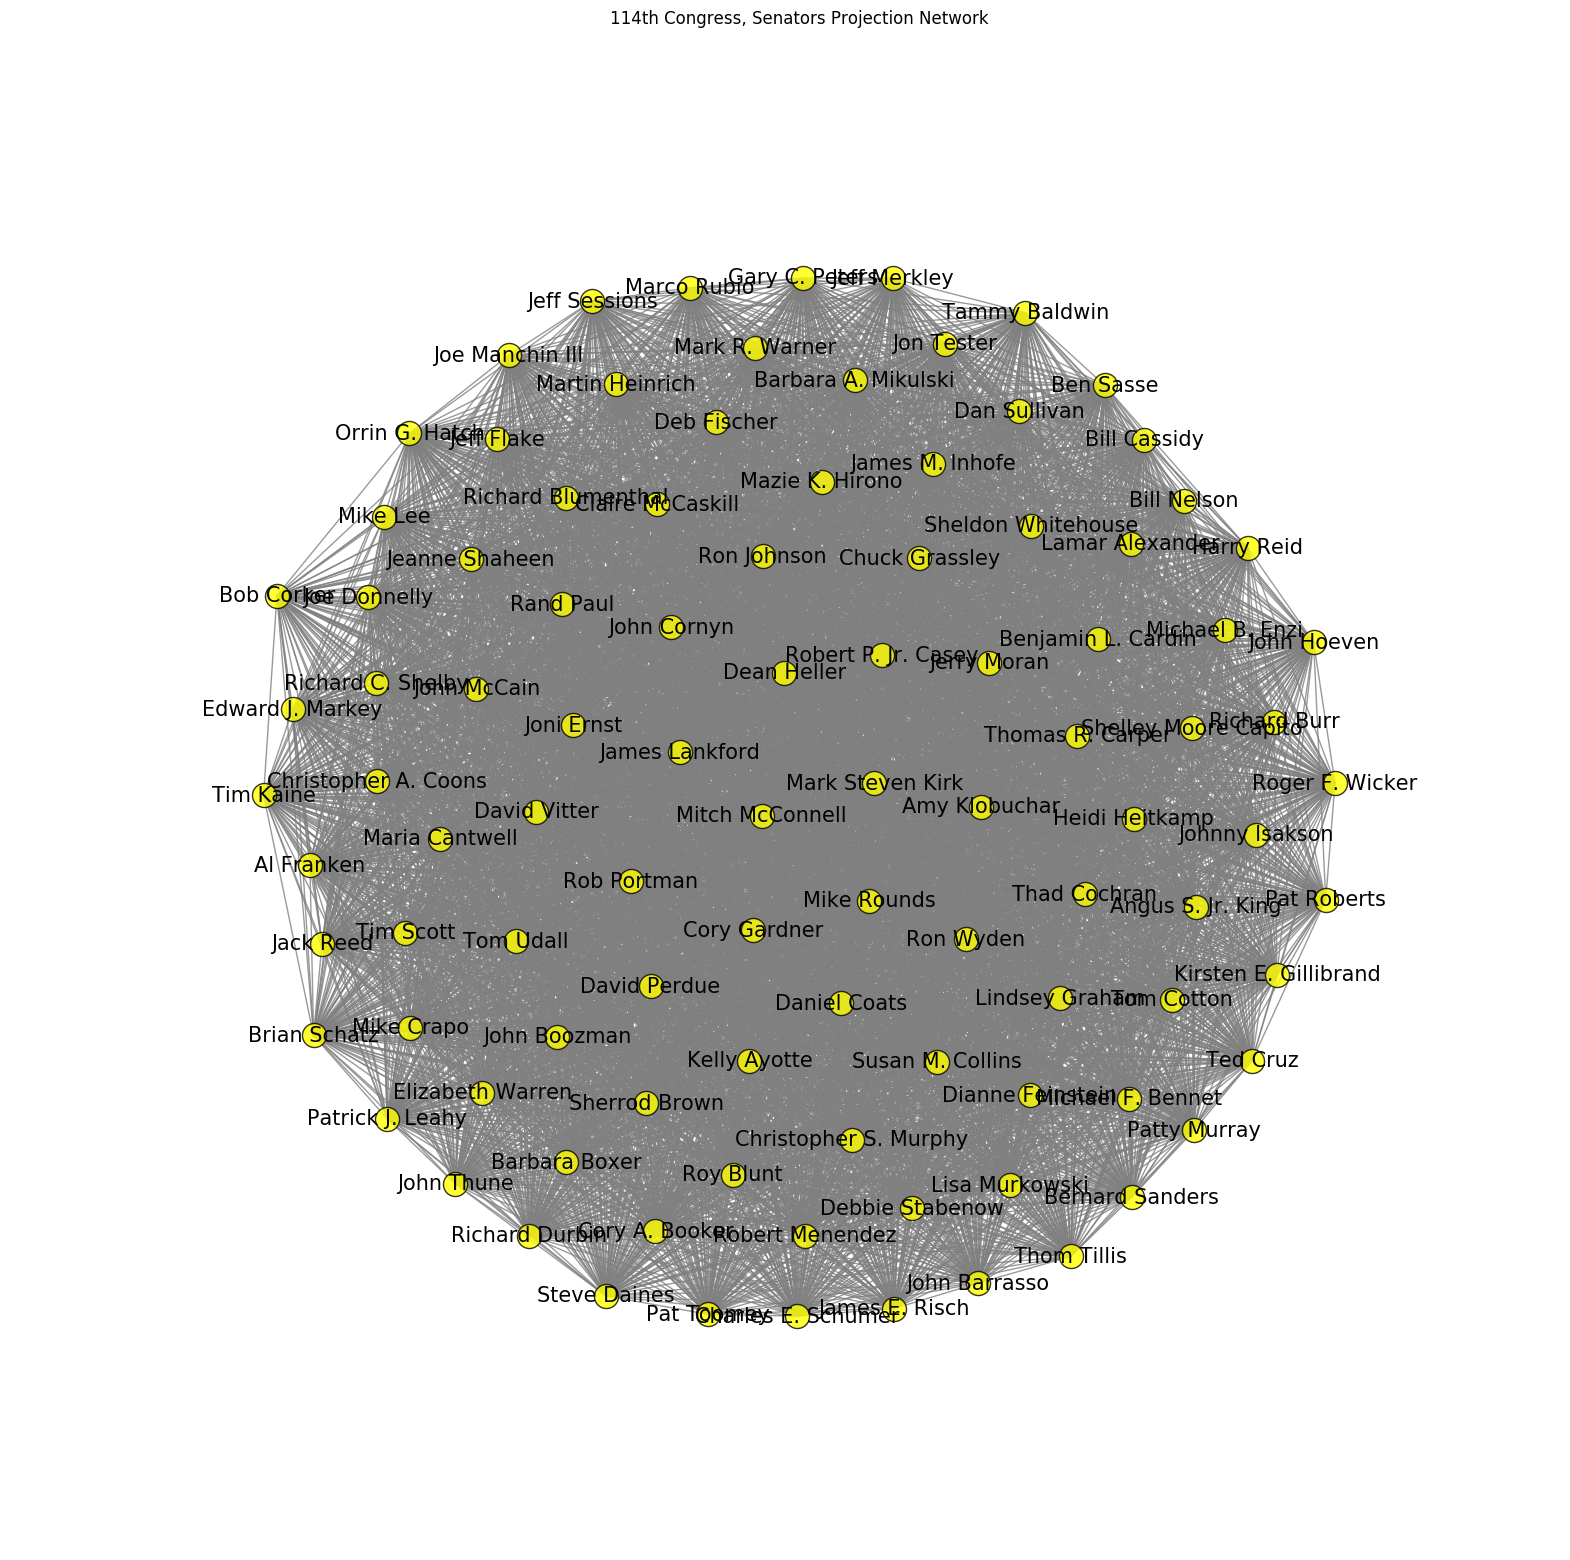

In [16]:
#Graph shows Senators are tightly connected.
G = bipartite.projected_graph(B, top_nodes, multigraph=False)

%matplotlib inline
fig = plt.figure(figsize=(15, 15))

pos = nx.spring_layout(G, k=0.6, iterations=25)
nx.draw(G, with_labels=True, pos=pos, font_size=15, alpha=.8, edge_color = 'grey', node_color = 'yellow')
plt.title('114th Congress, Senators Projection Network')
plt.show()

Following network is projected graph of bill subjects. 

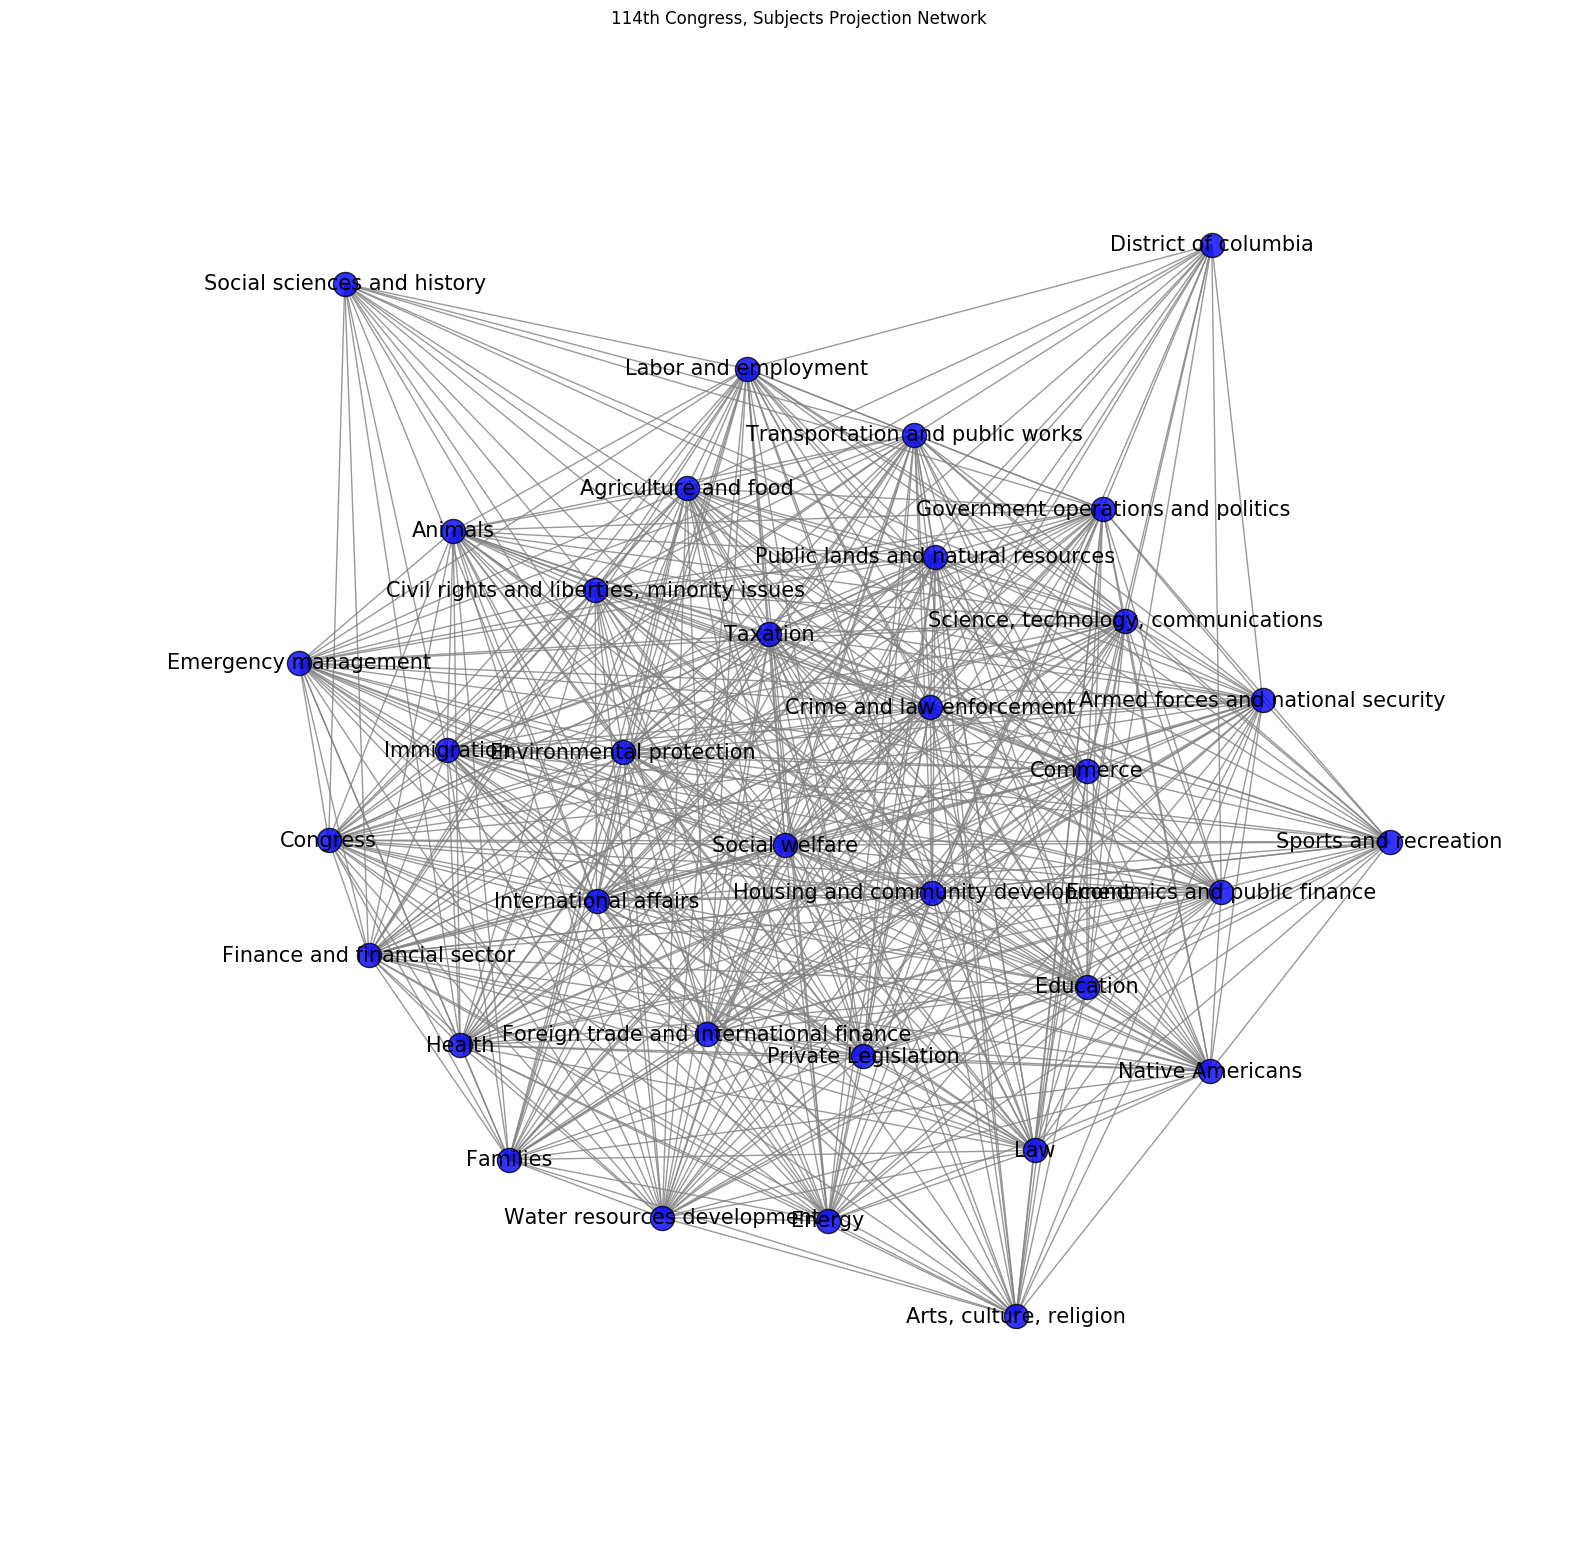

In [17]:
#Graph shows they are connected to the most part.
#Not all subjects are linked. Example: Social sciences & history and District of Columbia
#They were least popular among Senators

G = bipartite.projected_graph(B, bottom_nodes, multigraph=False)

%matplotlib inline
fig = plt.figure(figsize=(15, 15))

pos = nx.spring_layout(G, k=0.5, iterations=25)
nx.draw(G, with_labels=True, pos=pos, font_size=15, alpha=.8, edge_color = 'grey', node_color = 'b')
plt.title('114th Congress, Subjects Projection Network')
plt.show()

###Density

A Dense graph is a graph in which the number of edges is close to the maximal number of edges. Following shows nodes in each node-set are evenly dense. Output suggests it is not a dense graph.

In [18]:
#Density
print(bipartite.density(B,top_nodes))

print(bipartite.density(B,bottom_nodes))

0.3720588235294118
0.3720588235294118


###Clustering

Following data show, there is no clustering when a complete network is analyzed. In this case, the network is analyzed as a one-mode network. This type of clustering metrics does not provide a complete picture.

In [19]:
c = nx.clustering(B)
df = pd.DataFrame(list(c.items()), columns=['Node', 'Clustering'])
df.sort_values(['Clustering', 'Node'], ascending = False, inplace=True)
df

Node  Clustering
48                   Water resources development         0.0
131              Transportation and public works         0.0
111                                    Tom Udall         0.0
109                                   Tom Cotton         0.0
38                                     Tim Scott         0.0
15                                     Tim Kaine         0.0
54                              Thomas R. Carper         0.0
124                                  Thom Tillis         0.0
49                                  Thad Cochran         0.0
73                                      Ted Cruz         0.0
35                                      Taxation         0.0
40                                 Tammy Baldwin         0.0
77                              Susan M. Collins         0.0
75                                  Steve Daines         0.0
27                         Sports and recreation         0.0
122                               Social welfare         0.0
86                   Social sciences and history         0.0
70                                 Sherrod Brown         0.0
113                         Shelley Moore Capito         0.0
47                            Sheldon Whitehouse         0.0
117          Science, technology, communications         0.0
21                                     Roy Blunt         0.0
132                                    Ron Wyden         0.0
45                                   Ron Johnson         0.0
107                              Roger F. Wicker         0.0
79                           Robert P. Jr. Casey         0.0
34                               Robert Menendez         0.0
4                                    Rob Portman         0.0
52                                Richard Durbin         0.0
1                              Richard C. Shelby         0.0
..                                           ...         ...
5                                   David Perdue         0.0
102                                 Daniel Coats         0.0
108                                 Dan Sullivan         0.0
20                     Crime and law enforcement         0.0
71                                  Cory Gardner         0.0
33                                Cory A. Booker         0.0
126                                     Congress         0.0
3                                       Commerce         0.0
10                              Claire McCaskill         0.0
106  Civil rights and liberties, minority issues         0.0
39                                Chuck Grassley         0.0
82                         Christopher S. Murphy         0.0
94                          Christopher A. Coons         0.0
19                            Charles E. Schumer         0.0
23                                  Brian Schatz         0.0
97                                    Bob Corker         0.0
56                                   Bill Nelson         0.0
80                                  Bill Cassidy         0.0
11                               Bernard Sanders         0.0
14                            Benjamin L. Cardin         0.0
130                                    Ben Sasse         0.0
110                                Barbara Boxer         0.0
6                            Barbara A. Mikulski         0.0
96                       Arts, culture, religion         0.0
72            Armed forces and national security         0.0
57                                       Animals         0.0
32                             Angus S. Jr. King         0.0
100                                Amy Klobuchar         0.0
105                                   Al Franken         0.0
120                         Agriculture and food         0.0

[134 rows x 2 columns]

Two-mode clustering metrics show there is a high level of clustering around Senators Gary C. Peters, Senator Edward J. Markey and Senator Amy Klobuchar. In other words Senators are creating clusters around subjects. We can assume that Senators are more actively working on subjects.

In [20]:
c = bipartite.clustering(B)
df = pd.DataFrame(list(c.items()), columns=['Node', 'Clustering'])
df.sort_values(['Clustering', 'Node'], ascending = False, inplace=True)
df

Node  Clustering
7                                 Gary C. Peters    0.467979
83                              Edward J. Markey    0.466050
100                                Amy Klobuchar    0.465132
4                                    Rob Portman    0.458394
16                              Mark Steven Kirk    0.457735
66                                  Patty Murray    0.449602
40                                 Tammy Baldwin    0.443799
23                                  Brian Schatz    0.443223
121                               Orrin G. Hatch    0.438549
21                                     Roy Blunt    0.433688
110                                Barbara Boxer    0.429799
9                                    Dean Heller    0.428701
132                                    Ron Wyden    0.428436
58                                  Kelly Ayotte    0.427624
52                                Richard Durbin    0.424544
78                         Kirsten E. Gillibrand    0.424226
0                                    John Cornyn    0.423339
46                                  David Vitter    0.422189
128                               Jeanne Shaheen    0.421120
64                               Michael B. Enzi    0.416889
80                                  Bill Cassidy    0.415656
71                                  Cory Gardner    0.414451
98                                   Jerry Moran    0.406920
33                                Cory A. Booker    0.406413
42                                    John Thune    0.406024
11                               Bernard Sanders    0.404171
125                                  Marco Rubio    0.402996
82                         Christopher S. Murphy    0.402861
47                            Sheldon Whitehouse    0.398786
59                                    Jeff Flake    0.398304
..                                           ...         ...
63                                James Lankford    0.248444
76                                    Harry Reid    0.244810
5                                   David Perdue    0.236183
49                                  Thad Cochran    0.228641
133                 Economics and public finance    0.218295
122                               Social welfare    0.214168
24                                   Immigration    0.211763
50                                           Law    0.207037
120                         Agriculture and food    0.205080
74                                James E. Risch    0.201195
118      Foreign trade and international finance    0.200920
37                                   Mike Rounds    0.189306
130                                    Ben Sasse    0.185288
81                              Native Americans    0.174577
48                   Water resources development    0.169541
65             Housing and community development    0.167055
124                                  Thom Tillis    0.165161
1                              Richard C. Shelby    0.164930
22                                 Jeff Sessions    0.153204
57                                       Animals    0.148732
18                          Emergency management    0.145375
106  Civil rights and liberties, minority issues    0.126924
126                                     Congress    0.118515
12                                      Families    0.118401
97                                    Bob Corker    0.101726
84                           Private Legislation    0.082698
96                       Arts, culture, religion    0.053245
27                         Sports and recreation    0.042717
86                   Social sciences and history    0.032616
95                          District of columbia    0.025329

[134 rows x 2 columns]

###Local clustering coefficient for two-mode networks

Clustering values obtained using *Robins Alexander method* and *Global Average Method* differ because *Robins Alexander method* clustering coefficients for two-mode networks are based on 4-cycles, which is the smallest possible cycle in two-mode networks. Robins and Alexander defined a coefficient as the ratio between the number of 4-cycles and the number of 3-paths.

Whereas *Global Average Method* uses one-mode clustering coefficient to detect closure among three nodes. Hence the difference in values.

Reference: https://toreopsahl.com/tnet/two-mode-networks/clustering/

In [21]:
#Average clustering Robins Alexander method
print(round(bipartite.robins_alexander_clustering(B), 3))

#Average clustering
print(round(bipartite.average_clustering(B), 3))

0.552
0.316


###Subgroups

This occurrence of situations in which the nodes of a graph fall into two or more groups with some nodes acting as links between the groups. Following table shows subgroup formation between two different node sets.

In [22]:
def get_triangles(g):
    nodes = g.nodes()
    for n1 in nodes:
        neighbors1 = set(g[n1])
        for n2 in filter(lambda x: x>n1, nodes):
            neighbors2 = set(g[n2])
            common = neighbors1 & neighbors2
            for n3 in filter(lambda x: x>n2, common):
                yield n1, n2, n3
a = get_triangles(B)
df = pd.DataFrame(a)
df.columns = ['node1', 'node2', 'node3']
df

node1                 node2  \
0        John Cornyn     Richard C. Shelby   
1        John Cornyn           Rob Portman   
2        John Cornyn           Rob Portman   
3        John Cornyn           Rob Portman   
4        John Cornyn      Susan M. Collins   
5        John Cornyn       Lamar Alexander   
6        John Cornyn       Lamar Alexander   
7        John Cornyn             Roy Blunt   
8        John Cornyn             Roy Blunt   
9        John Cornyn             Roy Blunt   
10       John Cornyn        Johnny Isakson   
11       John Cornyn        Johnny Isakson   
12       John Cornyn        Lisa Murkowski   
13       John Cornyn        Lisa Murkowski   
14       John Cornyn        Lisa Murkowski   
15       John Cornyn           John McCain   
16       John Cornyn           John McCain   
17       John Cornyn           John McCain   
18       John Cornyn           John McCain   
19       John Cornyn            John Thune   
20       John Cornyn            John Thune   
21       John Cornyn            John Thune   
22       John Cornyn            John Thune   
23       John Cornyn          Richard Burr   
24       John Cornyn          Richard Burr   
25       John Cornyn            Pat Toomey   
26       John Cornyn           Ron Johnson   
27       John Cornyn    Sheldon Whitehouse   
28       John Cornyn    Sheldon Whitehouse   
29       John Cornyn          Thad Cochran   
...              ...                   ...   
12902      Ron Wyden      Susan M. Collins   
12903      Ron Wyden             Roy Blunt   
12904      Ron Wyden             Roy Blunt   
12905      Ron Wyden             Roy Blunt   
12906      Ron Wyden             Roy Blunt   
12907      Ron Wyden    Sheldon Whitehouse   
12908      Ron Wyden    Sheldon Whitehouse   
12909      Ron Wyden    Sheldon Whitehouse   
12910      Ron Wyden    Sheldon Whitehouse   
12911      Ron Wyden          Thad Cochran   
12912      Ron Wyden      Thomas R. Carper   
12913      Ron Wyden      Thomas R. Carper   
12914      Ron Wyden         Sherrod Brown   
12915      Ron Wyden         Sherrod Brown   
12916      Ron Wyden         Sherrod Brown   
12917      Ron Wyden          Steve Daines   
12918      Ron Wyden          Steve Daines   
12919      Ron Wyden             Tom Udall   
12920      Ron Wyden             Tom Udall   
12921      Ron Wyden  Shelley Moore Capito   
12922      Ron Wyden           Thom Tillis   
12923      Ron Wyden         Tammy Baldwin   
12924      Ron Wyden         Tammy Baldwin   
12925      Ron Wyden         Tammy Baldwin   
12926  Tammy Baldwin          Thad Cochran   
12927  Tammy Baldwin      Thomas R. Carper   
12928  Tammy Baldwin      Thomas R. Carper   
12929  Tammy Baldwin             Tom Udall   
12930  Tammy Baldwin             Tom Udall   
12931  Tammy Baldwin           Thom Tillis   

                                     node3  
0                                 Taxation  
1      Science, technology, communications  
2                                 Taxation  
3          Transportation and public works  
4                                 Taxation  
5                                 Taxation  
6       Public lands and natural resources  
7      Science, technology, communications  
8                                 Taxation  
9          Transportation and public works  
10      Public lands and natural resources  
11                                Taxation  
12      Public lands and natural resources  
13                                Taxation  
14         Transportation and public works  
15                                     Law  
16      Public lands and natural resources  
17                                Taxation  
18         Transportation and public works  
19     Science, technology, communications  
20      Public lands and natural resources  
21                                Taxation  
22         Transportation and public works  
23     Science, technology, communications  
24                                Tax

###Cliques

A clique is defined as a maximal complete subgraph of a given graph. Example: a group of nodes where every node is connected directly to every other node. The word *maximal* means that no other nodes can be added to the clique without making it less connected.

When the entire two-node graph is checked for cliques, bill subjects *Health* and *Taxation* ranked on the top. This explains Senator connecting to these bill subjects make a complete subgraph or a clique.

Bill subjects *Health* and *Taxation* connect more Senators, creating more cliques.

In [23]:
c = nx.number_of_cliques(B)
df = pd.DataFrame(list(c.items()), columns=['Node', 'Cliques'])
df.sort_values(['Cliques', 'Node'], ascending = False, inplace=True)
df

Node  Cliques
91                                    Health       88
35                                  Taxation       82
99        Public lands and natural resources       73
8         Government operations and politics       72
72        Armed forces and national security       71
131          Transportation and public works       61
20                 Crime and law enforcement       61
127                                Education       58
41                     International affairs       55
93              Finance and financial sector       55
88                  Environmental protection       54
116                                   Energy       51
3                                   Commerce       45
87                      Labor and employment       44
117      Science, technology, communications       42
133             Economics and public finance       36
122                           Social welfare       34
24                               Immigration       34
118  Foreign trade and international finance       32
81                          Native Americans       27
120                     Agriculture and food       27
50                                       Law       26
46                              David Vitter       23
48               Water resources development       22
65         Housing and community development       22
100                            Amy Klobuchar       21
59                                Jeff Flake       20
121                           Orrin G. Hatch       19
128                           Jeanne Shaheen       19
57                                   Animals       19
..                                       ...      ...
89                           Joe Manchin III       10
103                             Joe Donnelly       10
6                        Barbara A. Mikulski       10
105                               Al Franken       10
109                               Tom Cotton        9
15                                 Tim Kaine        9
123                          Martin Heinrich        9
38                                 Tim Scott        8
85                         Michael F. Bennet        8
67                            Lindsey Graham        8
17                           Lamar Alexander        8
102                             Daniel Coats        8
113                     Shelley Moore Capito        7
84                       Private Legislation        7
112                               Joni Ernst        7
63                            James Lankford        7
5                               David Perdue        7
49                              Thad Cochran        6
60                           Mitch McConnell        6
124                              Thom Tillis        5
37                               Mike Rounds        5
22                             Jeff Sessions        5
74                            James E. Risch        5
1                          Richard C. Shelby        4
130                                Ben Sasse        4
96                   Arts, culture, religion        4
27                     Sports and recreation        3
97                                Bob Corker        3
86               Social sciences and history        1
95                      District of columbia        1

[134 rows x 2 columns]

On a projected graph, bill subject *Transportation and public works* stand out. That means this subject is more popular among Senators.

In [24]:
G = bipartite.projected_graph(B, bottom_nodes, multigraph=False)
c = nx.number_of_cliques(G)
df = pd.DataFrame(list(c.items()), columns=['Node', 'Cliques'])
df.sort_values(['Cliques', 'Node'], ascending = False, inplace=True)
df

Node  Cliques
33              Transportation and public works        6
11          Science, technology, communications        6
1            Public lands and natural resources        6
0                         International affairs        6
23            Housing and community development        6
6            Government operations and politics        6
17                     Environmental protection        6
3                     Crime and law enforcement        6
2                                      Commerce        6
30                                     Taxation        5
15                               Social welfare        5
13                         Labor and employment        5
18                                  Immigration        5
19                                       Health        5
12      Foreign trade and international finance        5
5                  Finance and financial sector        5
29                                    Education        5
24                                     Congress        5
32           Armed forces and national security        5
20                         Agriculture and food        5
9                   Water resources development        4
31                             Native Americans        4
7                                           Law        4
10                                       Energy        4
16                 Economics and public finance        4
8                           Private Legislation        3
4   Civil rights and liberties, minority issues        3
27                                      Animals        3
28                                     Families        2
14                         Emergency management        2
22                        Sports and recreation        1
21                  Social sciences and history        1
26                         District of columbia        1
25                      Arts, culture, religion        1

On a projected graph, following table, shows subgroups among bill subjects. That means these subjects are more popular among Senators and bills connected to these subjects tend to make it floor more often.

In [25]:
def get_triangles(g):
    nodes = g.nodes()
    for n1 in nodes:
        neighbors1 = set(g[n1])
        for n2 in filter(lambda x: x>n1, nodes):
            neighbors2 = set(g[n2])
            common = neighbors1 & neighbors2
            for n3 in filter(lambda x: x>n2, common):
                yield n1, n2, n3

a = get_triangles(G)
df = pd.DataFrame(a)
df.columns = ['node1', 'node2', 'node3']
df

node1                               node2  \
0                     Commerce           Crime and law enforcement   
1                     Commerce           Crime and law enforcement   
2                     Commerce           Crime and law enforcement   
3                     Commerce           Crime and law enforcement   
4                     Commerce           Crime and law enforcement   
5                     Commerce           Crime and law enforcement   
6                     Commerce           Crime and law enforcement   
7                     Commerce           Crime and law enforcement   
8                     Commerce           Crime and law enforcement   
9                     Commerce           Crime and law enforcement   
10                    Commerce           Crime and law enforcement   
11                    Commerce           Crime and law enforcement   
12                    Commerce           Crime and law enforcement   
13                    Commerce           Crime and law enforcement   
14                    Commerce           Crime and law enforcement   
15                    Commerce           Crime and law enforcement   
16                    Commerce           Crime and law enforcement   
17                    Commerce           Crime and law enforcement   
18                    Commerce           Crime and law enforcement   
19                    Commerce           Crime and law enforcement   
20                    Commerce           Crime and law enforcement   
21                    Commerce           Crime and law enforcement   
22                    Commerce           Crime and law enforcement   
23                    Commerce           Crime and law enforcement   
24                    Commerce           Crime and law enforcement   
25                    Commerce           Crime and law enforcement   
26                    Commerce        Finance and financial sector   
27                    Commerce        Finance and financial sector   
28                    Commerce        Finance and financial sector   
29                    Commerce        Finance and financial sector   
...                        ...                                 ...   
5115  Environmental protection               Sports and recreation   
5116  Environmental protection               International affairs   
5117  Environmental protection               International affairs   
5118  Environmental protection               International affairs   
5119  Environmental protection               International affairs   
5120  Environmental protection               International affairs   
5121  Environmental protection               International affairs   
5122  Environmental protection               International affairs   
5123  Environmental protection               International affairs   
5124  Environmental protection               International affairs   
5125  Environmental protection               International affairs   
5126  Environmental protection               International affairs   
5127  Environmental protection               International affairs   
5128  Environmental protection  Public lands and natural resources   
5129  Environmental protection  Public lands and natural resources   
5130  Environmental protection  Public lands and natural resources   
5131  Environmental protection  Public lands and natural resources   
5132  Environmental protection  Public lands and natural resources   
5133  Environmental protection  Public lands and natural resources   
5134  Environmental protection  Public lands and natural resources   
5135  Environmental protection                            Taxation   
5136  Environmental protection                            Taxation   
5137  Environmental protection                    Native Americans   
5138  Environmental protection                    Native Americans   
5139  Environmental protection                    Native Americans   
5140  Environmental protection     

###Final Analysis

- Senators presenting most bills
- Subjects on which most bills are presented.

We will be using *island method* from chapter 4 of *Social Network Analysis for Startups*

In [26]:
def trim_edges(g, weight=1):
        g2=nx.Graph()
        for f, to, edata in g.edges(data=True):
                if edata['weight'] > weight:
                        g2.add_edge(f,to,edata)
        return g2
        
def island_method(g, iterations=5):
    weights= [edata['weight'] for f,to,edata in g.edges(data=True)]
    mn=int(min(weights))
    mx=int(max(weights))
    #compute the size of the step, so we get a reasonable step in iterations    
    step=int((mx-mn)/iterations)    
    return [[threshold, trim_edges(g, threshold)] for threshold in range(mn,mx,step)]
    
cc = max(nx.connected_component_subgraphs(B), key=len)
islands=island_method(cc)

Analysis: 

- When every Senator presents one bill on any of 34 subjects; network separates into 129 nodes and 129 islands.
- When the water level is raised 6 units, meaning removing Senators from the network who present less than 6 bills, network separates into 73 nodes and 73 islands.
- When the water level is raised 11 units, meaning removing Senators from the network who present less than 11 bills, network separates into 21 nodes and 3 islands. The first island has 7 nodes, the second island has 6 nodes and third has 8 nodes.
- When the water level is raised 21 units, meaning removing Senators from the network who present less than 21 bills, network separates into 4 nodes and 2 islands. Both islands have 2 nodes each.
- When the water level is raised the highest possible level, meaning removing Senators from the network who present less than 26 bills, network separates into 2 nodes and single island. This combination represents Senator presenting most bills and popular subject.


In [27]:
print ('%-25s %-45s %-13s' % ('Number of Bills', 'Nodes(Senetors + Subjects)', 'Islands'))
for i in islands:
    print ('%-25s %-45s %-13s' % (i[0], len(i[1]), [len(c) for c in nx.connected_component_subgraphs(i[1])]))

Number of Bills           Nodes(Senetors + Subjects)                    Islands      
1                         129                                           [129]        
6                         73                                            [73]         
11                        21                                            [7, 6, 8]    
16                        8                                             [3, 3, 2]    
21                        4                                             [2, 2]       
26                        2                                             [2]          


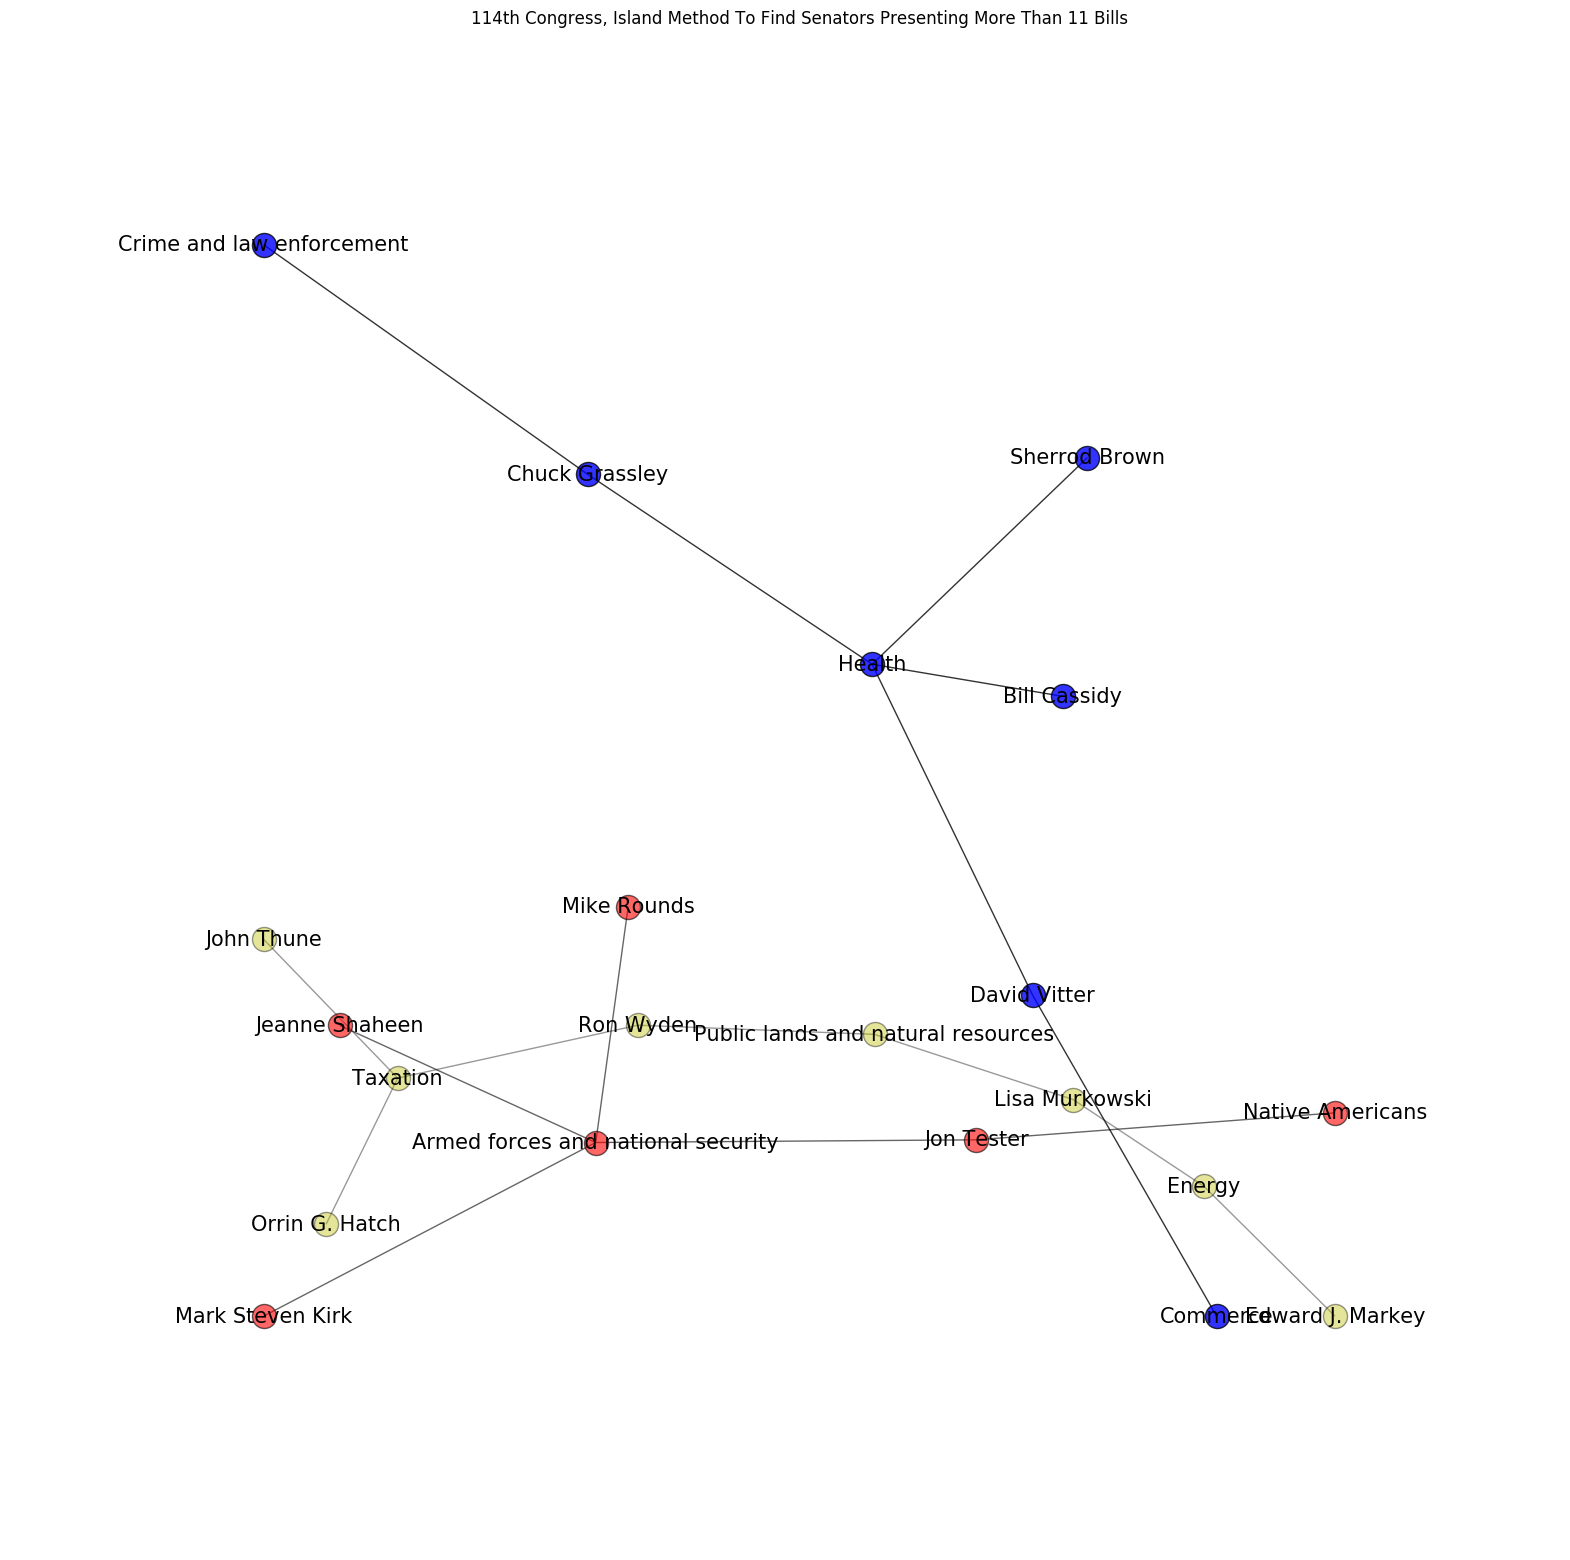

In [28]:
#Colors represent 3 different islands
%matplotlib inline
#pos = nx.erdos_renyi_graph(B)
fig = plt.figure(figsize=(15, 15))

for i in islands:
    if i[0] == 11:
        j = 0
        for c in nx.connected_component_subgraphs(i[1]):
            if j == 0:
                nx.draw(c, with_labels=True, font_size=15, alpha=.8, node_color = 'b')
            if j == 1:
                nx.draw(c, with_labels=True, font_size=15, alpha=.6, node_color = 'r')
            if j == 2:
                nx.draw(c, with_labels=True, font_size=15, alpha=.4, node_color = 'y')
            j = j + 1
            
plt.title('114th Congress, Island Method To Find Senators Presenting More Than 11 Bills')
plt.show()


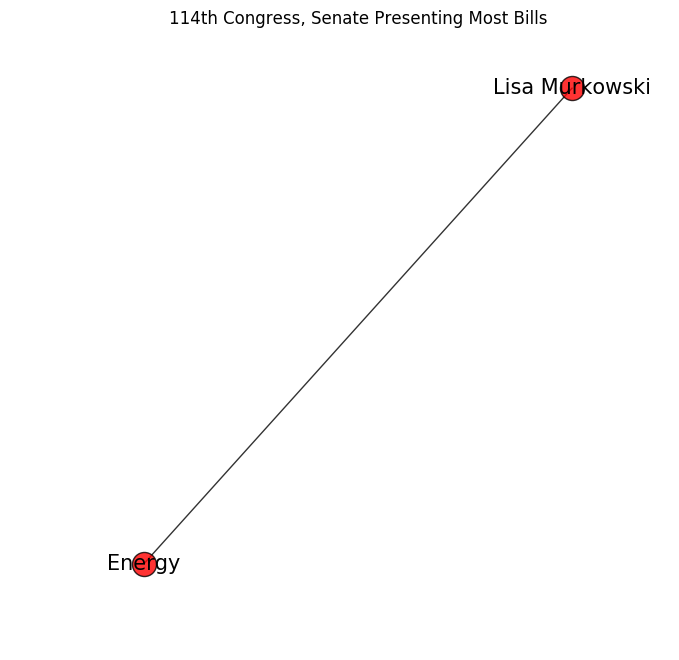

In [29]:
#Senetor presenting most bills on popular subject
%matplotlib inline
#pos = nx.erdos_renyi_graph(B)
fig = plt.figure(figsize=(6, 6))

for i in islands:
    if i[0] == 26:
        for c in nx.connected_component_subgraphs(i[1]):
            nx.draw(c, with_labels=True, font_size=15, alpha=.8, node_color = 'r')
            
plt.title('114th Congress, Senate Presenting Most Bills')
plt.show()